In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import imageio

from tensorflow.keras.models import Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

from sklearn.model_selection import train_test_split

import os
import shutil
import json
import zipfile

from sklearn.utils import resample
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

from PIL import Image
import cv2

Unzipping a specific zip file (histopathologic-cancer-detection.zip) located in /content/drive/MyDrive/ and extracting its contents to the /content folder.

In [2]:
def unzip_file(zip_filepath, dest_folder):
    with zipfile.ZipFile(zip_filepath, 'r') as zip_ref:
        zip_ref.extractall(dest_folder)

zip_file = '/content/drive/MyDrive/histopathologic-cancer-detection.zip'
destination_folder = '/content'

unzip_file(zip_file, destination_folder)

In [3]:
df_train = pd.read_csv("/content/train_labels.csv")
df_sample_sub = pd.read_csv("/content/sample_submission.csv")

# 2. Exploratory Data Analysis¶


In [7]:
df_train['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

There is a remarkable imbalance present in the data.
For this project I will use the resampling approach, namely undersampling since size of the data is sufficient.



In [9]:
# sample positive and negative images
sample_size = 80000
df_train_neg = df_train[df_train['label'] == 0].sample(sample_size, random_state=42)
df_train_pos = df_train[df_train['label'] == 1].sample(sample_size, random_state=42)

# creatimg a new shuffeled training dataset
df_train_sample = shuffle(pd.concat([df_train_pos, df_train_neg], axis=0).reset_index(drop=True))

In [10]:
df_train_sample['label'].value_counts()

1    80000
0    80000
Name: label, dtype: int64

Splitting data into train and valid datasets.

In [5]:
train_data, valid_data = train_test_split(df_train_sample, test_size=0.1, random_state=42)
train_data.to_csv('train_data.csv', index=False)
valid_data.to_csv('valid_data.csv', index=False)


# 3. Data Preprocessing

For data preprocessing, following methods are applied:

1.  Data augmentation

2.  Normalization

3. Splitting into training and validation set






In [6]:
def augment_image(image):
    # Applying data augmentation techniques here (random flips, rotations, brightness adjustments)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image

In [ ]:
!pip install tensorflow-io

In [8]:
import tensorflow_io as tfio

def load_image_and_label(file_path, label):
    # Reading the image from the file
    image = tf.io.read_file(file_path)

    # Decoding the TIFF image
    image = tfio.experimental.image.decode_tiff(image)

    # Converting into RGB
    image = image[:, :, :3]

    image = tf.image.resize(image, [96, 96])

    return image, label

def create_dataset_from_dataframe(df, image_folder):
    # Generating full paths to the images using the 'id' feature from the dataframe
    file_paths = image_folder + "/" + df['id'].astype(str) + ".tif"
    labels = df['label'].values

    # Creating a dataset from the file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    # Using the `map` method to load the images
    dataset = dataset.map(load_image_and_label, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(lambda image, label: (augment_image(image), label), num_parallel_calls=tf.data.experimental.AUTOTUNE)


    return dataset

In [9]:
images_folder = '/content/train'

train_dataset = create_dataset_from_dataframe(train_data, images_folder)
valid_dataset = create_dataset_from_dataframe(valid_data, images_folder)

# To improve performance, batching, shuffling, and prefetching datasets
train_dataset = train_dataset.shuffle(1024).batch(128).prefetch(tf.data.experimental.AUTOTUNE)
valid_dataset = valid_dataset.batch(128).prefetch(tf.data.experimental.AUTOTUNE)

Checking corectness of the dataset by printing some of the images.

(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)
(96, 96, 3)


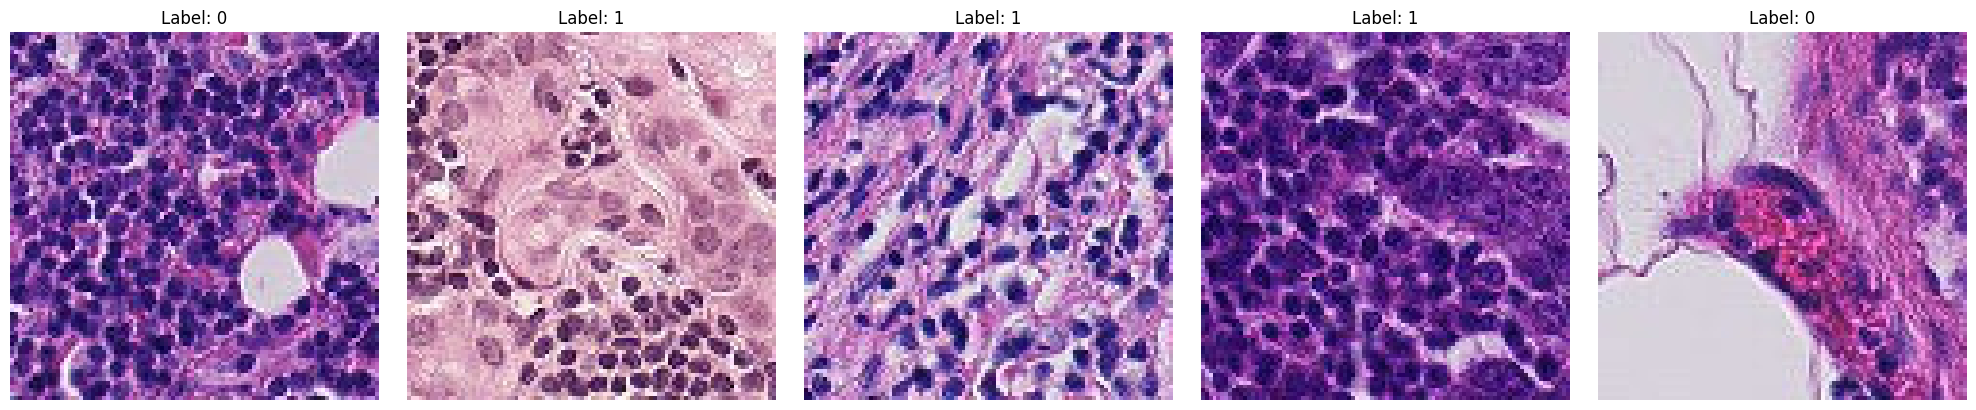

In [10]:
import matplotlib.pyplot as plt

def visualize_images(dataset, num_images=5):
    # Creating a figure
    plt.figure(figsize=(20, 4))

    # Extracting the first batch of images and labels from the dataset
    images, labels = next(iter(dataset))

    # Ensuring we don't request more images than exist in the batch
    num_images = min(num_images, images.shape[0])

    for i in range(num_images):
        plt.subplot(1, num_images, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        print(images[i].shape)
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# Visualizing images from the training dataset
visualize_images(train_dataset)


# 4. Model Building

Creating a convolutional neural network (CNN) using a pre-trained DenseNet121 model for binary classification.

It loads a pre-trained DenseNet121 model with weights pre-trained on the ImageNet dataset. This model is loaded without its top (fully connected) layers by setting include_top to False. The base_model variable now holds this pre-trained model.

Custom layers are added on top of the pre-trained model to adapt it for binary classification. 
DenseNet121 is a deep convolutional neural network architecture that has achieved state-of-the-art performance on various image classification tasks. It has demonstrated superior accuracy compared to earlier architectures like VGG, Inception, and ResNet on benchmark datasets like ImageNet.


In [12]:
# Load pretrained DenseNet121 model
base_model = DenseNet121(weights='imagenet', include_top=False)

# Adding custom layers for binary classification
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze layers in the base model (optional)
for layer in base_model.layers:
    layer.trainable = False


29084464/29084464 [==============================] - 0s 0us/step


Compiling and training a model for binary classification using the Adam optimizer and binary cross-entropy loss. Additionally, it's tracking the area under the ROC curve (AUC) as a metric during training.

In [13]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[AUC(name='auc')])

model.fit(train_dataset, epochs=10, validation_data=valid_dataset)


Epoch 1/10
1125/1125 [==============================] - 312s 241ms/step - loss: 0.4396 - auc: 0.8964 - val_loss: 0.3698 - val_auc: 0.9276
Epoch 2/10
1125/1125 [==============================] - 254s 224ms/step - loss: 0.3474 - auc: 0.9258 - val_loss: 0.3365 - val_auc: 0.9311
Epoch 3/10
1125/1125 [==============================] - 218s 193ms/step - loss: 0.3267 - auc: 0.9342 - val_loss: 0.3273 - val_auc: 0.9407
Epoch 4/10
1125/1125 [==============================] - 231s 204ms/step - loss: 0.3160 - auc: 0.9384 - val_loss: 0.3147 - val_auc: 0.9397
Epoch 5/10
1125/1125 [==============================] - 230s 204ms/step - loss: 0.3070 - auc: 0.9419 - val_loss: 0.3074 - val_auc: 0.9419
Epoch 6/10
1125/1125 [==============================] - 245s 216ms/step - loss: 0.2980 - auc: 0.9454 - val_loss: 0.2928 - val_auc: 0.9475
Epoch 7/10
1125/1125 [==============================] - 249s 220ms/step - loss: 0.2942 - auc: 0.9468 - val_loss: 0.3056 - val_auc: 0.9463
Epoch 8/10
1125/1125 [============

Now I will use this model to predict on the test data and create our submission file. In the future, I could use several pre-trained models to achieve better results. Overall, everything worked quite well. However, it would have been great to work with more epochs in order to get more precise results. The limited GPU memory really was a problem in this project since image data requires so much disk space.

In [14]:
images_folder_test = '/content/test'
predictions_dataset = create_dataset_from_dataframe(df_sample_sub, images_folder_test)
predictions_dataset = predictions_dataset.batch(128)

In [15]:
predictions = model.predict(predictions_dataset)
df_sample_sub['label'] = predictions
df_sample_sub.to_csv('submission6.csv', index=False)

449/449 [==============================] - 83s 179ms/step


In [16]:
from google.colab import files
files.download('submission6.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>